<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Light-Field-Methods" data-toc-modified-id="Light-Field-Methods-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Light Field Methods</a></span><ul class="toc-item"><li><span><a href="#Reading-and-displaying-light-fields" data-toc-modified-id="Reading-and-displaying-light-fields-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Reading and displaying light fields</a></span><ul class="toc-item"><li><span><a href="#Get-light-field-data" data-toc-modified-id="Get-light-field-data-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Get light field data</a></span></li><li><span><a href="#Reading-the-light-field" data-toc-modified-id="Reading-the-light-field-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Reading the light field</a></span></li><li><span><a href="#Displaying-the-center-sub-aperture-image-(SAI)" data-toc-modified-id="Displaying-the-center-sub-aperture-image-(SAI)-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>Displaying the center sub aperture image (SAI)</a></span></li><li><span><a href="#Display-different-SAIs" data-toc-modified-id="Display-different-SAIs-2.1.4"><span class="toc-item-num">2.1.4&nbsp;&nbsp;</span>Display different SAIs</a></span></li><li><span><a href="#Synthesize-a-full-aperture-image" data-toc-modified-id="Synthesize-a-full-aperture-image-2.1.5"><span class="toc-item-num">2.1.5&nbsp;&nbsp;</span>Synthesize a full aperture image</a></span></li></ul></li><li><span><a href="#Refocusing-with-light-fields" data-toc-modified-id="Refocusing-with-light-fields-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Refocusing with light fields</a></span></li><li><span><a href="#Mitsuba-plugin-for-light-field-camera" data-toc-modified-id="Mitsuba-plugin-for-light-field-camera-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Mitsuba plugin for light field camera</a></span></li><li><span><a href="#Schlieren-imaging" data-toc-modified-id="Schlieren-imaging-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Schlieren imaging</a></span><ul class="toc-item"><li><span><a href="#Quantitative-measurement-of-deflection-angles" data-toc-modified-id="Quantitative-measurement-of-deflection-angles-2.4.1"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span>Quantitative measurement of deflection angles</a></span></li><li><span><a href="#Mitsuba-plugin-for-schlieren-sensor" data-toc-modified-id="Mitsuba-plugin-for-schlieren-sensor-2.4.2"><span class="toc-item-num">2.4.2&nbsp;&nbsp;</span>Mitsuba plugin for schlieren sensor</a></span></li></ul></li><li><span><a href="#Light-field-displays" data-toc-modified-id="Light-field-displays-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Light field displays</a></span></li></ul></li></ul></div>

In [6]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy.signal as sig
from scipy.integrate import simpson
from IPython.display import SVG, display, IFrame, HTML
%matplotlib notebook
book = False

# Light Field Methods

## Reading and displaying light fields

### Get light field data

Download the HCI light field dataset (see 'A dataset and evaluation methodology for depth estimation on 4D light fields' by Honauer et al.) from https://lightfield-analysis.uni-konstanz.de/

### Reading the light field

Read light field from the bedroom scene from the HCI dataset and convert it into a 4D-structure `lf(m,n,j,k)` with `(m,n)` denoting the spatial coordinates and `(j,k)` denoting the angular coordinates.

In [24]:
path = 'figures/3/bedroom/'

tmp = cv2.cvtColor(np.uint8(255*plt.imread(f"{path}input_Cam000.png")), cv2.COLOR_RGB2GRAY)
lf = np.zeros((tmp.shape[0], tmp.shape[1], 9, 9), dtype = 'uint8')
for j in range(0,9):
    for k in range(0,9):
        imgStr = str(j*9+k)
        while len(imgStr) < 3:
            imgStr = f"0{imgStr}"
        curImg = cv2.cvtColor(np.uint8(255*plt.imread(f"{path}input_Cam{imgStr}.png")), cv2.COLOR_RGB2GRAY)
        lf[:,:,j,k] = curImg

In [25]:
def imshow(img, cmap=None):
    plt.close('all')
    plt.figure()
    plt.imshow(img, cmap=cmap)
    plt.show()

In [26]:
def imshow2(img, cmap=None):
    #plt.close('all')
    #plt.figure()
    plt.clf()
    plt.imshow(img, cmap=cmap)
    #plt.show()

### Displaying the center sub aperture image (SAI)

Show center SAI for $\mathbf{j}=(4,4)^\intercal$:

<IPython.core.display.Javascript object>


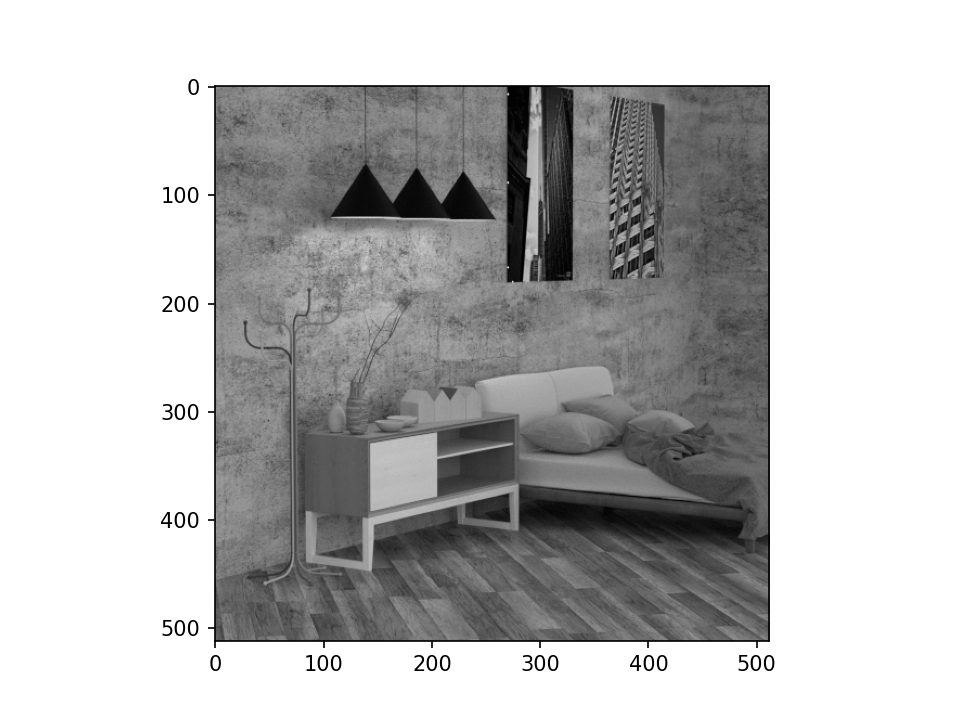

In [27]:
imshow(lf[:,:,4,4], cmap='gray')

### Display different SAIs

Visualize how the perspective changes when the horizontal angular coordinate is changed continuosly.

<IPython.core.display.Javascript object>


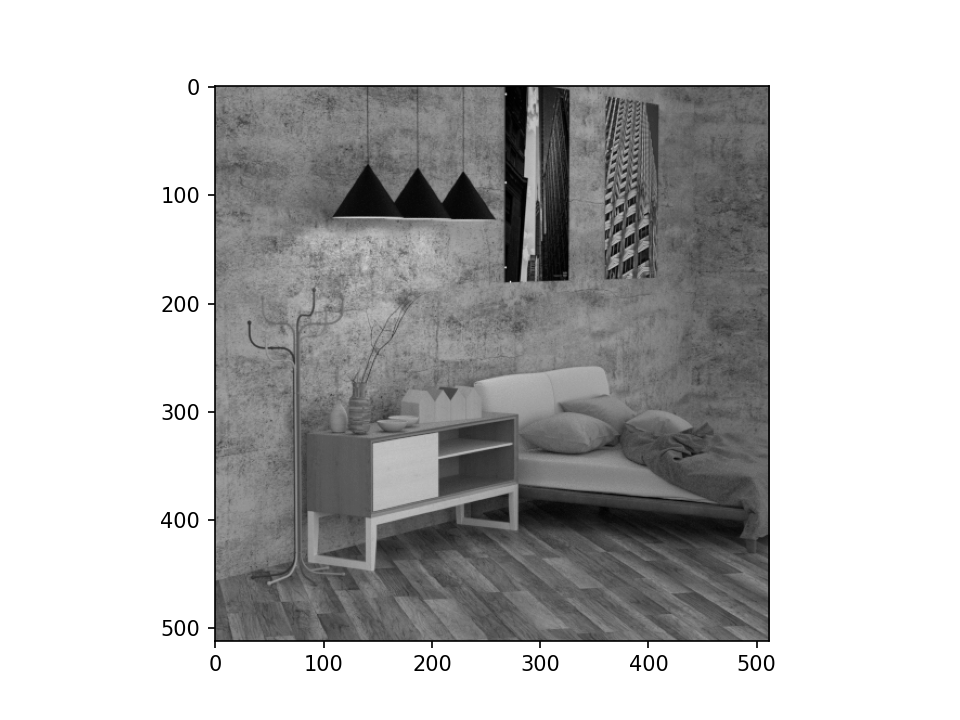

interactive(children=(IntSlider(value=4, description='j', max=8), Output()), _dom_classes=('widget-interact',)…

<function __main__.<lambda>(j)>

In [28]:
plt.figure()
interact(lambda j: imshow2(lf[:,:,4,j], cmap='gray'), j=widgets.IntSlider(min=0,max=8, step=1, value=4))

### Synthesize a full aperture image

Synthesize full aperture image, i.e., $g(\mathbf{m})=\sum\limits_{\mathbf{j}\in\Omega_\mathrm{a}} L(\mathbf{m},\mathbf{j})\,$:

<IPython.core.display.Javascript object>


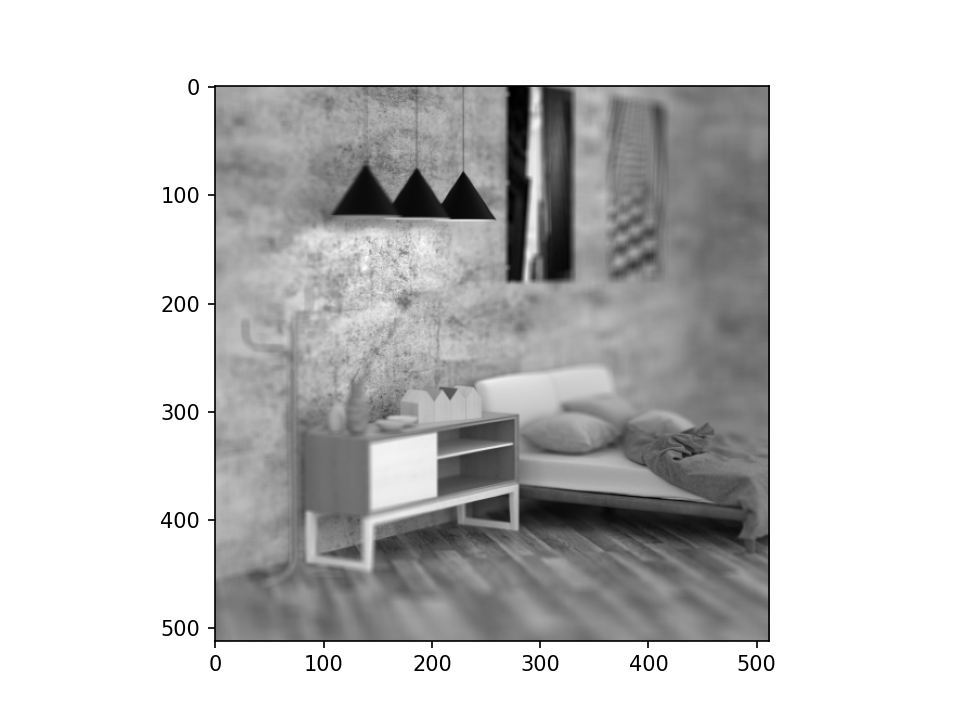

In [29]:
imshow(np.sum(np.sum(lf,axis=2),axis=2), cmap='gray')

## Refocusing with light fields

Define a refocus function `refocus(alpha)` by means of the shift and add-method as shown in the lecture.

Hint: To realize the shift-operation, have a look at OpenCV whether there is a suitable function.

In [30]:
def refocus(alpha):
    refocused = np.zeros_like(lf[:,:,0,0])
    refocused = np.float32(refocused)

    for v in range(0,lf.shape[2]):
        for u in range(0,lf.shape[3]):
            curShift = np.array([[1, 0, u*(1-1/alpha)],
                                 [0, 1, v*(1-1/alpha)]], dtype='float32')
            curSAI = np.float32(lf[:,:,v,u])
            curSAIShifted = cv2.warpAffine(curSAI, curShift, (curSAI.shape[1], curSAI.shape[0]))

            refocused = refocused + curSAIShifted
    
    return refocused

Visualize the refocusing results for different $\alpha$:

<IPython.core.display.Javascript object>


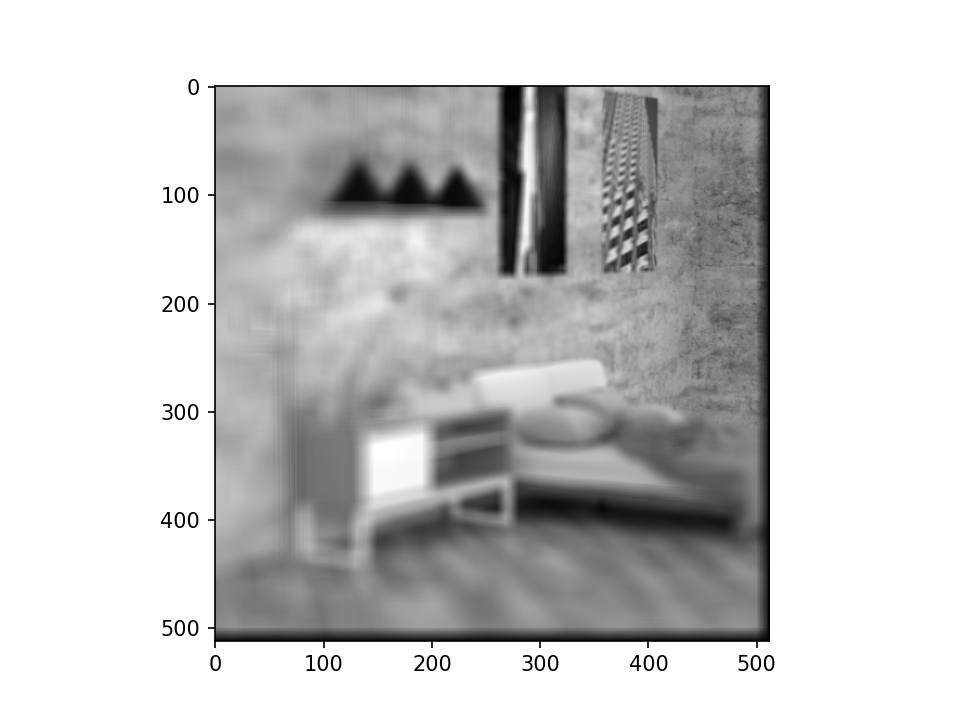

interactive(children=(FloatSlider(value=1.0, description='alpha', max=3.0, min=0.4, step=0.2), Output()), _dom…

<function __main__.<lambda>(alpha)>

In [31]:
plt.figure()
interact(lambda alpha: imshow2(refocus(alpha),cmap='gray'), alpha=widgets.FloatSlider(min=0.4,max=3.0, step=0.2, value=1.0))

## Mitsuba plugin for light field camera

Implement a Mitsuba plugin that realizes a light field camera based on a micro-lens array as introduced in the lecture. Assume circular lenses and no crosstalk. Save the light field as a single spatially multiplexed image.

In [32]:
variant = "scalar_rgb"
#variant = "cuda_ad_rgb"
#variant = "llvm_ad_rgb"

import os as os
os.environ["MI_DEFAULT_VARIANT"] = variant

import mitsuba as mi
import drjit as dr
import matplotlib.pyplot as plt

mi.set_variant(variant)

In [10]:
class light_field_sensor (mi.Sensor):
    def __init__(self, props):
        mi.Sensor.__init__(self, props)
        self.to_world = props['to_world']
        self.foc_len  = props['foc_len']
        self.img_dist_l = props['img_dist_l']
        self.img_dist_ml = props['img_dist_ml']
        self.sen_size = props['sen_size']
        
        self.ang_res = props['ang_res']
        self.filmsize = (self.sen_size, self.sen_size)
        
        self.spat_res = self.film().size()[0] / self.ang_res
        self.ml_diam = self.sen_size / self.spat_res
        self.ml_rad = self.ml_diam / 2
            
    def sample_ray_differential(self, time, sample1, sample2, sample3, active=True):
        weight = 1.0
        
        
        p_s = mi.Point3f((sample2[0]-0.5) * self.filmsize[0], (sample2[1]-0.5) * self.filmsize[1], -1.0 * self.img_dist_ml)
                
        # Which micro lens? --> determine index ml = (j,k) of corresponding micro lens
        ml = dr.floor((sample2*self.filmsize) / self.ml_diam)
                    
        # Determine coords of center of corresponding micro lens
        p_ml = mi.Point3f(ml[0] * self.ml_diam + self.ml_diam/2 - (self.spat_res * self.ml_diam) / 2, \
                          ml[1] * self.ml_diam + self.ml_diam/2 - (self.spat_res * self.ml_diam) / 2, \
                          -1 * self.img_dist_l)
        if dr.sqrt((p_ml[0]-p_s[0])**2 + (p_ml[1]-p_s[1])**2) > self.ml_rad:
            weight = 0.0
                
        
        # Determine point on main lens corresponding to center of micro lens
        p_l_1 = (p_ml - p_s) / self.img_dist_ml * self.img_dist_l + p_ml
        p_l_1[2] = 0.0
        

        # Determine point on main lens corresponding to aperture sample on micro lens
        p_a_2d = self.ml_rad * mi.warp.square_to_uniform_disk_concentric(sample3)
        p_a_offset = mi.Point3f(p_a_2d[0], p_a_2d[1], 0.0)
        p_l_2 = p_l_1 + p_a_offset
        
                        
        # Determine focused world point w.r.t. center of determined micro lens
        p_o = p_ml / (-1.0 * self.img_dist_l) * 1/(1/self.foc_len - 1/self.img_dist_l)
        
        
        rayd = mi.RayDifferential3f()
        rayd.has_differentials = False
        
        rayd.o = p_l_2
        rayd.d = p_o - p_l_2
        
        rayd.d = dr.normalize(rayd.d)
        rayd.d = self.to_world.transform_affine(rayd.d)
        
        return (rayd, mi.Color3f(weight, weight, weight))

In [11]:
mi.register_sensor("light_field_sensor", lambda props: light_field_sensor(props))

In [12]:
g = 8.0
b = 12
b_ml = 4
f = 1/(1/b + 1/g)
#f,b,g,V

In [13]:
scene = mi.load_dict({
    'type': 'scene',
    'integrator': {
        'type': 'path'
    },

    'sphere' : {
        'type': 'sphere',
        'emitter': {
            'type': 'area',
            'radiance': {
            'type': 'rgb',
            'value': 0.8,
        },
    },
    'center': [0, 0, g],
    'radius': 0.7,
        
    },
    'sphere2' : {
        'type': 'sphere',
        'emitter': {
            'type': 'area',
            'radiance': {
            'type': 'rgb',
            'value': 0.8,
        },
    },
    'center': [-2, -2, g+1],
    'radius': 0.4,
        
    },
 
    'sensor': {
        'type': 'light_field_sensor',
        'to_world': mi.ScalarTransform4f.look_at(origin=[0, 0, 0],
                                                 target=[0, 0, 1],
                                                 up=[0, 1, 0]),
        'foc_len' : f,
        'img_dist_l': b,
        'img_dist_ml': b_ml,
        'sen_size': 10.0,
        'ang_res': 5,
        'film': {'type': 'hdrfilm',
      'width': 500,
      'height': 500,
      'rfilter': {'type': 'gaussian'},
      'pixel_format': 'rgb',
      'component_format': 'float32'},
     'sampler': {'type': 'independent', 'sample_count': 4},
    }
})

In [14]:
image = mi.render(scene)

In [15]:
np.save("ex02_lf_image", image)

<IPython.core.display.Javascript object>


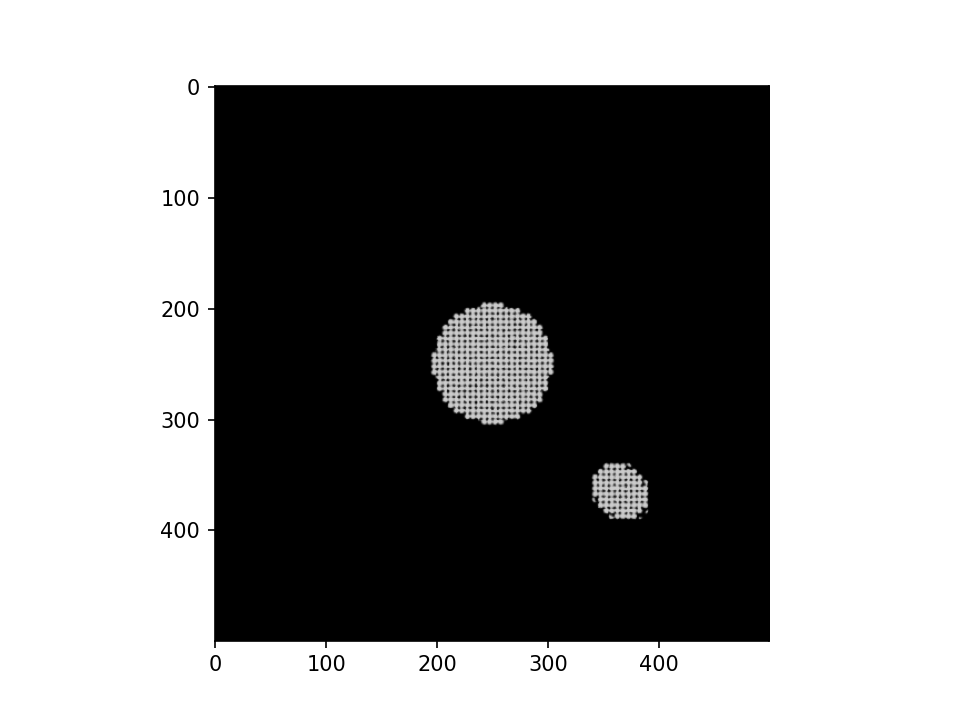

In [33]:
plt.figure()
plt.imshow(image)

In [34]:
image = np.array(image)
if len(image.shape) > 2:
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
lf = np.zeros((np.int32(image.shape[0]/5), np.int32(image.shape[1]/5), 5, 5))
for j in range(0,5):
    for k in range(0,5):
        curImg = image[j:image.shape[0]:5, k:image.shape[0]:5]
        lf[:,:,j,k] = curImg

<IPython.core.display.Javascript object>


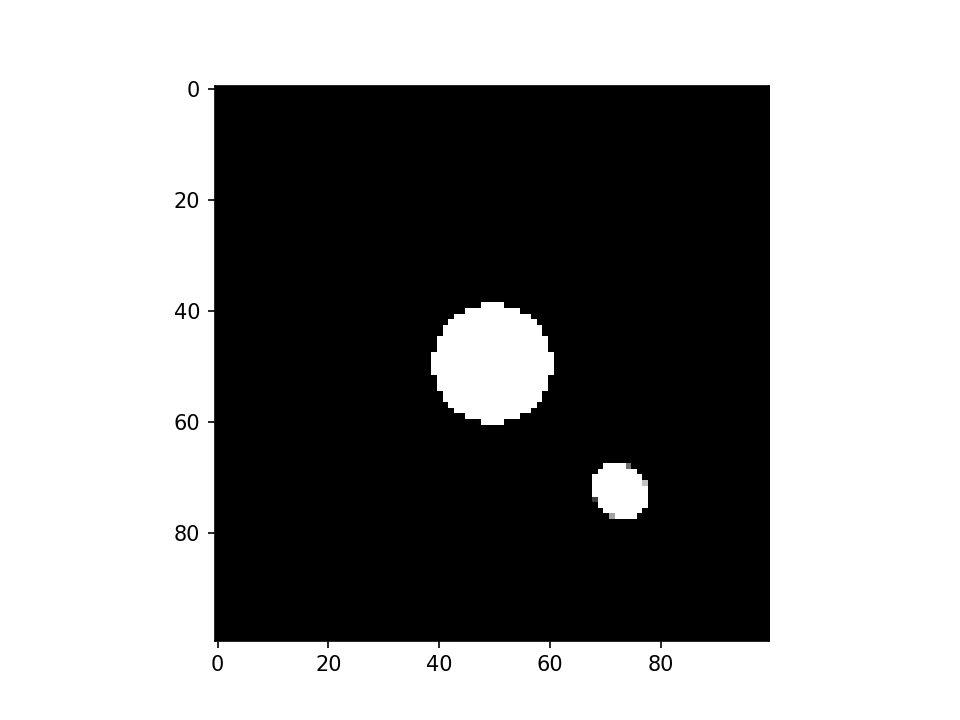

In [35]:
imshow(lf[:,:,2,2], cmap='gray')

## Schlieren imaging

### Quantitative measurement of deflection angles

In the lecture we learned:

Quantitative measurements of the deflection angle $\alpha$ are only possible if

$$ \delta_\alpha > \frac{1}{2}\varepsilon\,, $$

with $\varepsilon$ denoting the diameter of the image of the light source.

Explain why this is true.

**Answer**:<br>Since in practice, the light source can not be an ideal point light source, it will lead to light rays which do not propagate parallel to the optical axis in the measurement field. As a result, the image of the light source on the plane of the Schlieren stop also does not resemble an ideal point but some non-zero area. Any rays which are deflected by an angle $\alpha$ in the measurement field which results in a displacement $\delta_\alpha$ on the Schlieren stop, which does not exceed the area covered by the image of the light source, i.e., for which $\delta_\alpha \leq \frac{1}{2}\varepsilon$ can not be distinguished from light rays which are deflected because of the spatial extent of the light source and not because of an refractive effect in the measurement field.

### Mitsuba plugin for schlieren sensor

Implement a color-coded Schlieren setup in the Mitsuba rendering framework.

Encode the color-wheel via the HSI color space as follows:
* The angle is encoded via the hue value and
* the radius is encoded via the intensity value.

In [16]:
class color_schlieren_sensor (mi.Sensor):
    def __init__(self, props):
        mi.Sensor.__init__(self, props)
        self.to_world = props['to_world']
        self.foc_len  = props['foc_len']
        self.img_dist = props['img_dist']
        self.sen_size = props['sen_size']
        self.lens_rad = props['lens_rad']
        self.filmsize = (self.sen_size, self.sen_size)
        self.rad_max = (self.lens_rad - self.sen_size / 2) / self.img_dist * (self.img_dist - self.foc_len) + self.sen_size / 2
        
    def sample_ray_differential(self, time, sample1, sample2, sample3, active=True):
        
        p_a_2d = self.lens_rad * mi.warp.square_to_uniform_disk_concentric(sample3)
        p_a = mi.Point3f(p_a_2d[0], p_a_2d[1], 0.0)
        
        p_s = mi.Point3f((sample2[0]-0.5) * self.filmsize[0], (sample2[1]-0.5) * self.filmsize[1], -1.0 * self.img_dist)
        
        p_o = p_s / (-1.0 * self.img_dist) * 1/(1/self.foc_len - 1/self.img_dist)
        
        rayd = mi.RayDifferential3f()
        rayd.has_differentials = False
        
        rayd.o = p_a
        rayd.d = p_o - p_a
        
        rayd.d = dr.normalize(rayd.d)
        rayd.d = self.to_world.transform_affine(rayd.d)
        
        ### Calculate color wheel influence
        p_f = (p_a - p_s) / self.img_dist * (self.img_dist - self.foc_len) + p_s
        radius = dr.sqrt(p_f[0]**2 + p_f[1]**2)
        alpha = dr.atan2(p_f[1] , p_f[0])
                
        color_hsi = np.zeros((1,1,3), dtype=np.uint8)
        color_hsi[0,0,:] = [255*((alpha + dr.pi) / (2*dr.pi)), 255.0, 255*min(1.0, radius / self.rad_max ) ]
        
        color_rgb = cv2.cvtColor(color_hsi, cv2.COLOR_HSV2RGB)
        color_rgb = np.float64(color_rgb) / 255.0
        
        
        return (rayd, mi.Color3f(color_rgb[0,0,0], color_rgb[0,0,1], color_rgb[0,0,2]))

    
    def to_string(self):
        return ('thin_lens_sensor[\n'
                '    foc_len=%s,\n'
                '    img_dist=%s,\n'
                '    sen_size=%s,\n'
                '    lens_rad=%s,\n'
                ']' % (self.foc_len, self.img_dist, self.sen_size, self.lens_rad))
        

In [17]:
mi.register_sensor("color_schlieren_sensor", lambda props: color_schlieren_sensor(props))

In [18]:
class telecentric_area_light (mi.Emitter):
    def __init__(self, props):
        mi.Emitter.__init__(self, props)
        self.acc_angle = dr.deg2rad(props['acc_angle'])
        self.radiance = mi.Color3f(props['radiance'])
        self.flags = mi.EmitterFlags.Surface | mi.EmitterFlags.SpatiallyVarying
    
    def angleBetweenVectors(self, a:mi.Vector3f, b:mi.Vector3f):
        return dr.acos(dr.dot(a,b) / (dr.norm(a) * dr.norm(b)))
    
    def eval(self, si:mi.SurfaceInteraction3f, active=True):
        
        res = mi.Color3f(0.0, 0.0, 0.0)
        
        if self.angleBetweenVectors(si.n, si.wi * -1.0) <= self.acc_angle:
            res = self.radiance
        
        return res

    def sample_direction(self, it:mi.Interaction3f, sample, active=True):
        dirsam = mi.DirectionSample3f()
        return (mi.DirectionSample3f(), mi.Color3f())
    
    def to_string(self):
        return ('telecentric_area_light[\n'
                '    acc_angle=%s,\n'
                '    radiance=%s,\n'
                ']' % (dr.rad2deg(self.acc_angle), self.radiance))
mi.register_emitter("telecentric_area_light", lambda props: telecentric_area_light(props))

In [19]:
g = 8.0
V = 2.0
f = g/(1/V+1)
b = 1/(1/f - 1/g)
f,b,g,V

(5.333333333333333, 16.0, 8.0, 2.0)

In [20]:
scene = mi.load_dict({
    'type': 'scene',
    'integrator': {
        'type': 'path'
    },

    'rect' : {
        'type': 'rectangle',
        'emitter': {
            'type': 'telecentric_area_light',
            'radiance': mi.Color3f(1.0,1.0,1.0),
            'acc_angle': 25.0
    },
        'flip_normals' : True,
        'to_world': mi.Transform4f.translate(mi.Point3f(0,0,g+4))@mi.Transform4f.scale(mi.Point3f(2,2,2))
        
    },
    
    
          'sphere' : {
        'type': 'sphere',
              'bsdf' : {
        'type' : 'dielectric'
    },
    'center': [0, 0, g],
    'radius': 1.5,
        
    },
    
    
    'sensor': {
        'type': 'color_schlieren_sensor',
        'to_world': mi.ScalarTransform4f.look_at(origin=[0, 0, 0],
                                                 target=[0, 0, 1],
                                                 up=[0, 1, 0]),
        'foc_len' : f,
        'img_dist': b,
        'sen_size': 10.0,
        'lens_rad': 10.0,
        'film': {'type': 'hdrfilm',
      'width': 100,
      'height': 100,
      'rfilter': {'type': 'gaussian'},
      'pixel_format': 'rgb',
      'component_format': 'float32'},
     'sampler': {'type': 'independent', 'sample_count': 32},
    }
})


In [21]:
image2 = mi.render(scene)

In [23]:
np.save("ex02_color_schlieren", image2)

<IPython.core.display.Javascript object>


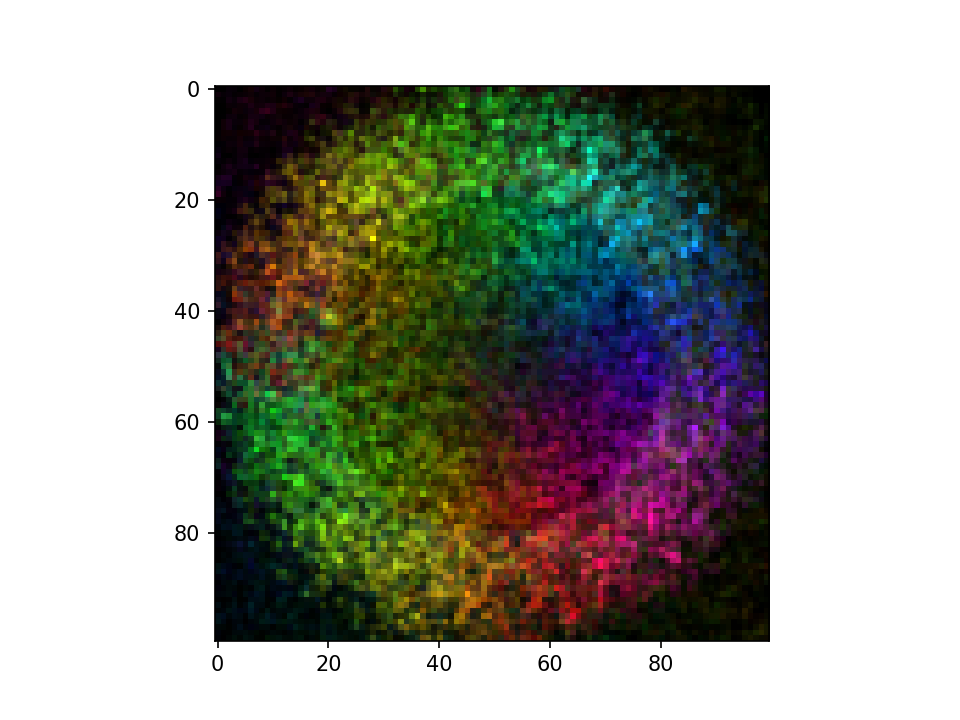

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [36]:
imshow(10*image2)

## Light field displays

The following images (also shown in the lecture) are acquired for a light field display prototype with a total range of possible angles of $10^\circ$ in both directions.

<img src="figures/3/lfgCalibResults.svg" style="max-height:40vh">

How can one explain the bottom right image?

**Answer**:<br>The developed prototype supports an angular resolution of about $1.23^\circ$ with a total range of around $12.27^\circ$. When capturing at $11^\circ$, the rays of sight of the camera are directed to pixels which correspond to adjacent microlenses, i.e., the image is affected by crosstalk.